# Problema 52
## 52)
Utilizaremos un código **Particle Mesh** suavizando a las partículas con **NGP** para integrar el movimiento de $n=100$ partículas de igual masa en un box periódico 1-dimensional de lado $L=100$, dividido en $N=100$ celdas de ancho $\Delta = \frac{L}{N} = 1$, utilizando técnicas ***FFT*** para el cálculo del potencial en cada celda. <br>
Luego, obtenemos la aceleración sobre cada celda de la forma:
### <center> $-\triangledown \phi = \vec a$ </center>
### <center> $-\frac{\phi_{i+1} -\phi_{i-1}}{2\Delta} \approx a_{x,i}$ </center>
Una vez obtenida la aceleración de cada partícula, resta aplicar **LF-KDK** y obtener las nuevas posiciones de las partículas, con un paso en el tiempo de $h=0.1$ a lo largo de $10000$ pasos.

In [15]:
#Copiamos y pegamos lo realizado para el problema 50), solo que ahora usamos 1000 partículas en un box 1-D
#de 100 celdas, y pedimos interacción gravitatoria:

import matplotlib.pyplot as plt
import numpy as np
from numpy import linalg as LA

n = 10000 #Cant de pasos
h = 0.1 #¿Intervalo de tiempo?
c = 100 #L
c_ = np.arange(c/2,3*c/2)
N = 100 #cant de partículas

x = np.zeros((n,N)) #pos para todo t (columna i => part i)

for i in range(N):
    x[0,i] = np.random.uniform(0,c)

#Poisson: FFT => ^phi = ^g(k)*^rho(k)
#^g(k) = -4*pi*G/k^2
#rho(k) = 1/N^3 * FFT rho(x_p) (sumado sobre p = "índice de celda" = L/N * i, con i = {0,...,c})

#Multiplico y luego aplico "inverseFFT", sumado sobre (k = número de onda)

#En este caso 1-D, k = (2*pi/L) * i, con i = {0,...,c}

#Luego, escribamos ^g(k):

k = np.zeros(c)
for i in range(c):
    k[i] = (2*np.pi/c)*i

def Gk(k):
    gk = np.zeros(c)
    for i in range(len(k)):
        if k[i] == 0:
            gk[i] = 0
        else:
            gk[i] = -4*np.pi/(k[i]**2)
        
    return gk

#Si no, g(x-x'):

def Green(x):
    g = -1/(abs(x))
    return g

#Veamos la rho:

def Rhop(l,x=x):
    px = np.zeros(c) #Cant de part en cada celda
    j = 0
    while j < N:
        for i in range(c):
            if i <= x[l,j] < (i+1):
                px[i] += 1
        j += 1

    #A rho hay que actualizarla, para actualizar a phi
    #print(px)

    rho = 1e-7*px
    
    return rho

def Rhok(rho,k):
    rhok = np.fft.fft(rho,c)
    return rhok

#Calc rho (que hay que actualizar) y pbtengamos phi (a cada step)

def pot(l,x=x,Gk=Gk,k=k):
    
    rho = Rhop(l,x)
    rhok = Rhok(rho,k)
    
    g = Gk(k)
    
    phik = g*rhok
    
    phi = np.fft.ifft(phik)
    
    return phi

In [16]:
k_ = 2*np.pi/c_
k_

#Calculo a:

def a(phi,l,x=x):
    a = np.zeros(N) #una a según la celda (por NGP (sino tendría que interpolar)), y 1 a por partícula
    j = 0
    while j < N:
        for i in range(c):
            if i <= x[l,j] < i+1: #Si hay un part en la celda...
                if i != c-1:
                    a[j] = -(phi[i+1] - phi[i-1])/2 #interpolo lo que se va a aplicar a la partícula
                else:
                    a[j] = -(phi[0] - phi[i-1])/2
                    
        j += 1

    return a

def LF_KDK(a=a,x=x,h=h,n=n,vx=np.zeros(N),Green=Green):
    
    kx = np.zeros(N)
    
    rhoNGP = np.zeros((c,c)) #Para el plot
    
    for l in range(n-1):
        
        #rho = Rhop(l,x)
        #phi = signal.fftconvolve(Green(c_), rho, mode='same')
        phi = pot(l,x,Gk,k_)
        phi = np.abs(phi)
        
        for i in range(N):
            if x[l,i] > c or x[l,i] < 0:
                x[l,i] = x[l,i] % c

        #Una vez conseguido phi, evolucionemos a c/ partícula:
        
        for k in range(N):
            kx[k] = vx[k] + a(phi,l,x=x)[k]*h/2
        for k in range(N):
            x[l+1,k] = x[l,k] + kx[k]*h
        for k in range(N):
            vx[k] = kx[k] + a(phi,l,x=x)[k]*h/2
        
        if l%100 == 0:
            
            rho = Rhop(l,x)
            
            rhoNGP[c//2,:] = rho
            rhoNGP[(c//2)-1,:] = rho
            
            """plt.figure(figsize=(16,10))
            graf = plt.contourf(X,Y,(rhoNGP*1e+7),antialiased=False,vmin=0,vmax=5)
            cb = plt.colorbar(graf)
            cb.set_label(label='Cantidad de partículas', size='x-large')
            plt.yticks([0],fontsize=10)
            plt.xlabel('x',fontsize=20)
            plt.title(f'Mapa de densidades en el box 1-D para NGP \n{c} celdas ; {N} partículas',fontsize=20)
            plt.grid(True,c='white',lw=0.2)
            plt.xlim(0,c)""";
            
            plt.figure(figsize=(13,13))
            plt.scatter([x[l,:]],np.zeros(N),c='b',alpha=0.4,s=20)
            plt.yticks([0],fontsize=15)
            #plt.xticks([i for i in range(c)],fontsize=15)
            plt.xlabel('x',fontsize=20)
            plt.grid(True,c='k',lw=0.2)
            plt.xlim(0,c)
            
            plt.savefig(f'PM_{l}.jpg')
            plt.close()
        
    return x

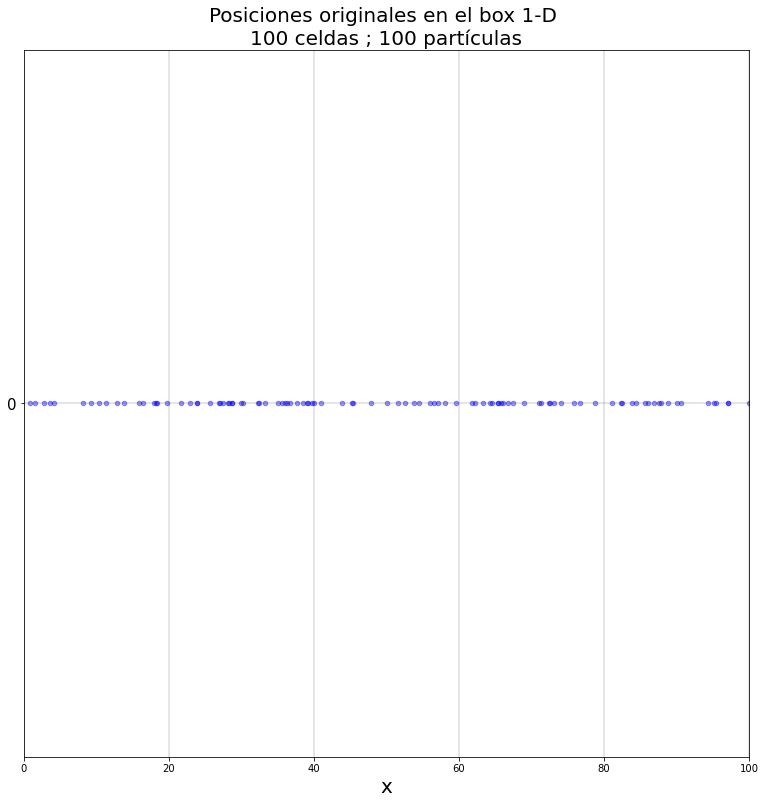

In [19]:
plt.figure(figsize=(13,13))
plt.title(f'Posiciones originales en el box 1-D \n{c} celdas ; {N} partículas',fontsize=20)
plt.scatter([x[0,:]],np.zeros(N),c='b',alpha=0.4,s=20)
plt.yticks([0],fontsize=15)
#plt.xticks([i for i in range(c)],fontsize=15)
plt.xlabel('x',fontsize=20)
plt.grid(True,c='k',lw=0.2)
plt.xlim(0,c);

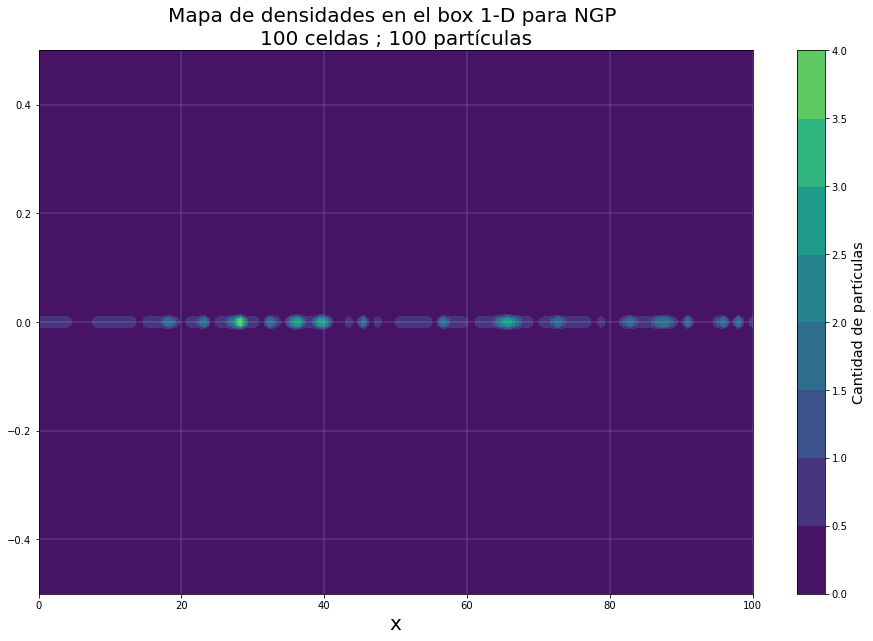

In [18]:
xx = np.linspace(0,c,c)
yy = np.linspace(-1/2,1/2,c)
X,Y = np.meshgrid(xx,yy)

rho = Rhop(0,x)
rhoNGP = np.zeros((c,c))
rhoNGP[c//2,:] = rho
rhoNGP[(c//2)-1,:] = rho

plt.figure(figsize=(16,10))
graf = plt.contourf(X,Y,(rhoNGP*1e+7),antialiased=False,vmin=0,vmax=5)
cb = plt.colorbar(graf)
cb.set_label(label='Cantidad de partículas', size='x-large')
#plt.xticks([i for i in range(L+1)],fontsize=3)
#plt.yticks([i for i in range(L+1)],fontsize=3)
plt.xlabel('x',fontsize=20)
plt.title(f'Mapa de densidades en el box 1-D para NGP \n{c} celdas ; {N} partículas',fontsize=20)
plt.grid(True,c='white',lw=0.2)

No realizaremos de nuevo la integración, pero dejamos las animaciones correspondientes en los siguientes enlaces:

**Posiciones a lo largo de toda la integración:**

https://drive.google.com/file/d/1nk8_bjBxwJuRc9m5urhbfnIE5hoXARv9/view?usp=sharing

**Mapa de densidades (por celda) a lo largo de toda la integración:**

https://drive.google.com/file/d/1OIA-_DRQ8MshtDr3Yx3gK62EA-YRUD23/view?usp=sharing

Y como para que se vea que realmente funciona nuestro código, realizamos una mini-integración de sólo 2 partículas, para corroborar que *la gravedad funcione bien...*

https://drive.google.com/file/d/1SUi6jxJ9nx0ex-7CatmAUQxucPUy5PxE/view?usp=sharing

In [14]:
#x = LF_KDK()